Quickshift number of segments: 5110


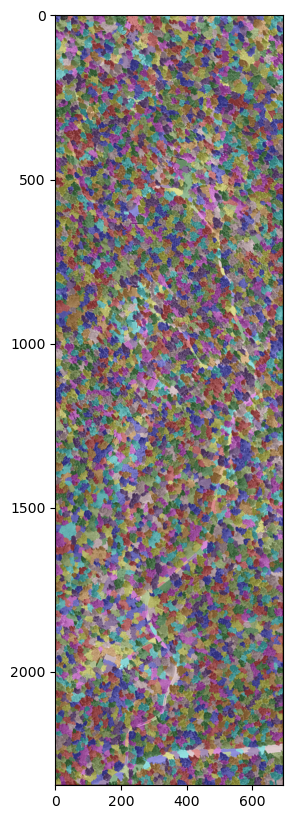

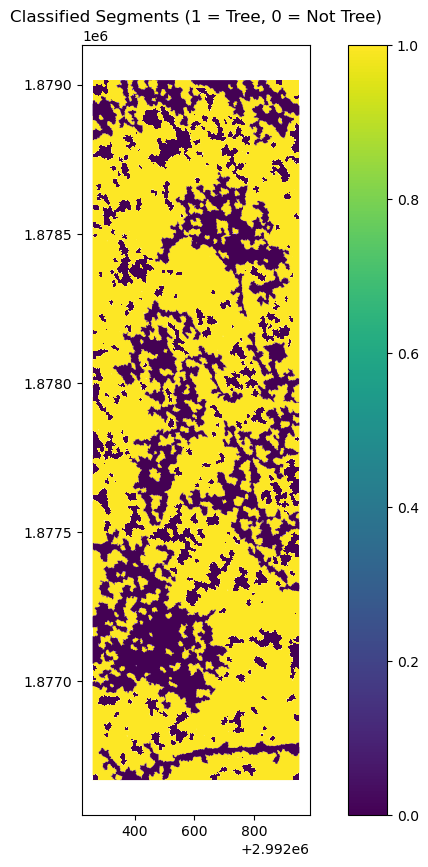

In [33]:
from skimage import io, color
from skimage.segmentation import quickshift, mark_boundaries
from rasterio.features import shapes
import numpy as np
import rasterio
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
from sklearn.cluster import KMeans

# Load the image and bands
tilepath = "../scratch/cropped_N4W351.tif"
tile = rasterio.open(tilepath)

red = tile.read(1).astype(float)
green = tile.read(2).astype(float)
blue = tile.read(3).astype(float)
nir = tile.read(4).astype(float)

# Get image bounding box info
sr = tile.crs
bounds = tile.bounds
affine = tile.transform

# Create a Polygon from the bounding box
minx, miny, maxx, maxy = bounds
bounds_polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

# Create a GeoDataFrame with the original bounds
bounds_gdf = gpd.GeoDataFrame(geometry=[bounds_polygon], crs=sr)

# Segment the image using quickshift
img = io.imread(tilepath)
img = img[:, :, :3]
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# Convert segments to vector features
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

# View the segments via Python
plt.figure(figsize=(10, 10))
plt.imshow(color.label2rgb(segments, img, bg_label=0))

# Compute mean values for each band in each segment
bands = np.stack([red, green, blue, nir], axis=-1)
mean_vals = []
for shp in polys:
    mask = rasterio.features.geometry_mask([shp], transform=affine, invert=True, out_shape=bands.shape[:2])
    mean_vals.append(bands[mask].mean(axis=0))

mean_vals = np.array(mean_vals)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(mean_vals)
labels = kmeans.labels_

# Create GeoDataFrame with segments and their cluster labels
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry': geom, 'cluster': labels}, crs=sr)

# Assuming cluster 0 is 'not tree' and cluster 1 is 'tree' (this can vary based on the data)
# You might need to inspect the characteristics of each cluster to determine which is which
# For example, assume higher mean NIR indicates trees, you can adjust based on your data
if mean_vals[labels == 0, 3].mean() > mean_vals[labels == 1, 3].mean():
    gdf['class'] = gdf['cluster']
else:
    gdf['class'] = 1 - gdf['cluster']

# Dissolve polygons by 'class' to merge connected polygons
dissolved_gdfs = []
for cls in gdf['class'].unique():
    class_gdf = gdf[gdf['class'] == cls]
    dissolved_gdf = class_gdf.dissolve()
    dissolved_gdf['class'] = cls
    dissolved_gdfs.append(dissolved_gdf)

# Combine the dissolved GeoDataFrames
dissolved_gdf = gpd.GeoDataFrame(pd.concat(dissolved_gdfs, ignore_index=True), crs=sr)

# Save the classified segments to a shapefile
# dissolved_gdf.to_file('dissolved_classified_segments.shp')

# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

In [34]:
dissolved_gdf

,geometry,cluster,class
0,"MULTIPOLYGON (((2992277.000 1876674.000, 29922...",1,1
1,"MULTIPOLYGON (((2992274.000 1876683.000, 29922...",0,0


     class  area_feet  area_acres
0        1   928041.0   21.304890
1        1        2.0    0.000046
2        1     3826.0    0.087833
3        1        1.0    0.000023
4        1     7107.0    0.163154
..     ...        ...         ...
401      0        3.0    0.000069
402      0        1.0    0.000023
403      0      653.0    0.014991
404      0     1925.0    0.044192
405      0      169.0    0.003880

[406 rows x 3 columns]


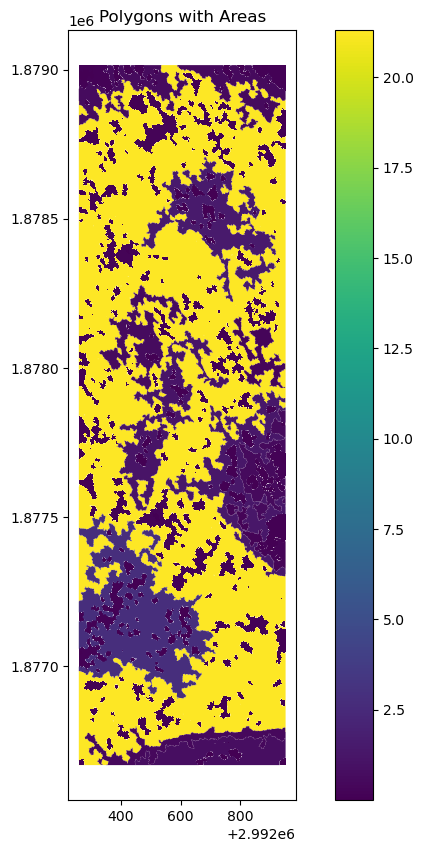

In [35]:
from shapely.geometry import Polygon, MultiPolygon

# Convert multipolygons to individual polygons
def multipolygons_to_polygons(dissolved_gdf):
    polygons = []
    classes = []
    for idx, row in dissolved_gdf.iterrows():
        if isinstance(row.geometry, MultiPolygon):
            for poly in row.geometry.geoms:  # Corrected line
                polygons.append(poly)
                classes.append(row['class'])
        else:
            polygons.append(row.geometry)
            classes.append(row['class'])
    return gpd.GeoDataFrame({'geometry': polygons, 'class': classes}, crs=dissolved_gdf.crs)

# Calculate area
def calculate_area(gdf):
    gdf['area_feet'] = gdf.geometry.area
    gdf['area_acres'] = gdf['area_feet'] / 43560
    return gdf

# Convert multipolygons to polygons
polygons_gdf = multipolygons_to_polygons(dissolved_gdf)

# Calculate areas
polygons_gdf = calculate_area(polygons_gdf)

# Output the areas
print(polygons_gdf[['class', 'area_feet', 'area_acres']])

# Plot the polygons with their areas
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf.plot(column='area_acres', ax=ax, legend=True, cmap='viridis')
plt.title("Polygons with Areas")
plt.show()


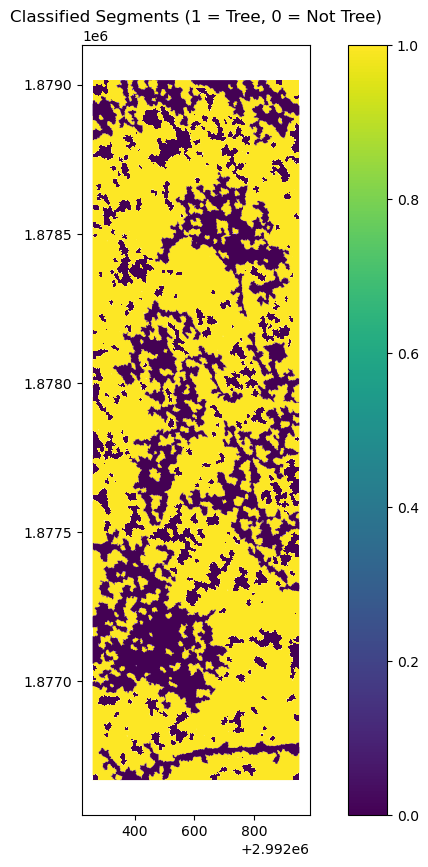

In [36]:
# Plot the classified segments
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf.plot(column='class', ax=ax, legend=True, cmap='viridis')
plt.title("Classified Segments (1 = Tree, 0 = Not Tree)")
plt.show()

/Users/ed.chan/miniconda3/envs/treebeard/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


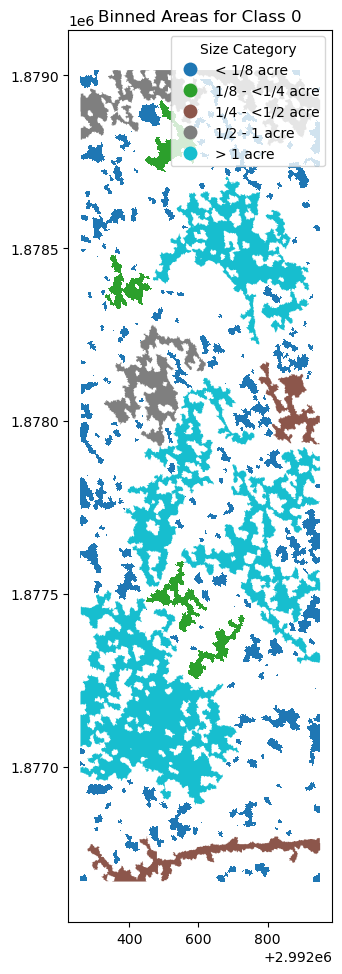

size_category
< 1/8 acre         276
1/8 - <1/4 acre      4
> 1 acre             4
1/2 - 1 acre         3
1/4 - <1/2 acre      2
Name: count, dtype: int64


In [37]:
import pandas as pd

# Function to bin and plot the areas
def bin_plot(gdf, bins, labels, title):
    gdf['size_category'] = pd.cut(gdf['area_acres'], bins=bins, labels=labels, right=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot = gdf.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
    ax.set_title(title)
    plt.tight_layout()
    filename = title.split('.')[0]
    plt.savefig(f'{filename}.png')
    plt.show()

# Filter the GeoDataFrame for class = 0
openspace_gdf = polygons_gdf[polygons_gdf['class'] == 0]
canopy_gdf = polygons_gdf[polygons_gdf['class'] == 1]

# Define bins and labels
bins = [0, 1/8, 1/4, 1/2, 1, float('inf')]  # Added infinity to cover areas larger than 1 acre
labels = ['< 1/8 acre', '1/8 - <1/4 acre', '1/4 - <1/2 acre', '1/2 - 1 acre', '> 1 acre']

# Plot the binned areas
bin_plot(openspace_gdf, bins, labels, "Binned Areas for Class 0")

# Display binned area counts for validation
print(openspace_gdf['size_category'].value_counts())

In [38]:
canopy_gdf

,geometry,class,area_feet,area_acres
0,"POLYGON ((2992277.000 1876674.000, 2992277.000...",1,928041.0,21.304890
1,"POLYGON ((2992288.000 1876991.000, 2992289.000...",1,2.0,0.000046
2,"POLYGON ((2992266.000 1877004.000, 2992268.000...",1,3826.0,0.087833
3,"POLYGON ((2992282.000 1877070.000, 2992283.000...",1,1.0,0.000023
4,"POLYGON ((2992302.000 1877121.000, 2992300.000...",1,7107.0,0.163154
...,...,...,...,...
112,"POLYGON ((2992905.000 1877871.000, 2992908.000...",1,594.0,0.013636
113,"POLYGON ((2992901.000 1878430.000, 2992899.000...",1,2.0,0.000046
114,"POLYGON ((2992893.000 1878885.000, 2992894.000...",1,220.0,0.005051
115,"POLYGON ((2992947.000 1877459.000, 2992943.000...",1,168.0,0.003857


In [39]:
canopy_gdf = canopy_gdf[['geometry', 'area_feet', 'area_acres']]

In [40]:
canopy_gdf.crs

<Projected CRS: EPSG:6428>
Name: NAD83(2011) / Colorado Central (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
canopy_gdf.to_file('../scratch/canopy_gdf.shp')

Text(0.5, 1.0, 'Canopy Polygons with Areas')

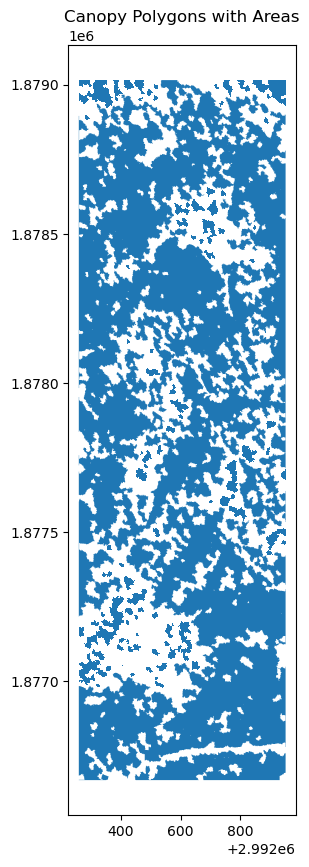

In [17]:
# plot
fig, ax = plt.subplots(figsize=(10, 10))
canopy_gdf.plot(ax=ax)
plt.title("Canopy Polygons with Areas")

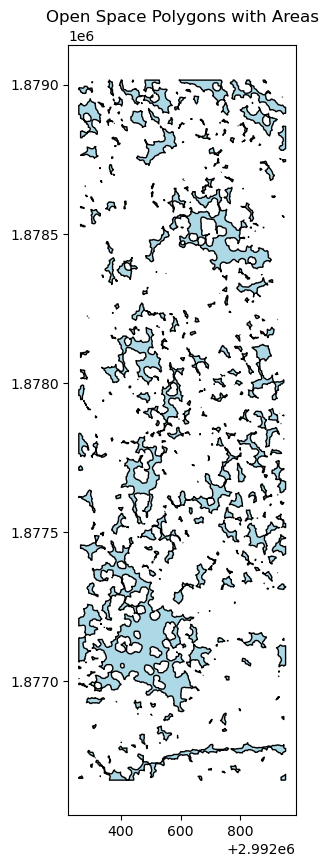

In [47]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# Buffer the canopy polygons by 5 feet
canopy_buffer = canopy_gdf.buffer(5) # in the right projection

# Create a GeoDataFrame from the buffered canopy polygons
buffered_gdf = gpd.GeoDataFrame(geometry=canopy_buffer, crs=canopy_gdf.crs)

# Clip the buffered canopy polygons to the original bounds
canopy_buffer_clipped = gpd.clip(buffered_gdf, bounds_gdf)

# Create a unary union of the clipped buffer polygons
buffer_union = unary_union(canopy_buffer_clipped.geometry)

# Invert the buffer to get the open space polygons
openspace_polygons = bounds_gdf.geometry.difference(buffer_union)

# Create a GeoDataFrame for the open space polygons
openspace_gdf2 = gpd.GeoDataFrame(geometry=openspace_polygons, crs=sr)

# Plot the open space polygons
fig, ax = plt.subplots(figsize=(10, 10))
openspace_gdf2.plot(ax=ax, color='lightblue', edgecolor='black')
plt.title("Open Space Polygons with Areas")
plt.show()


In [54]:
def classless_multipolygons_to_polygons(gdf):
    polygons = []
    for idx, row in gdf.iterrows():
        if isinstance(row.geometry, MultiPolygon):
            for poly in row.geometry.geoms:
                polygons.append(poly)
        else:
            polygons.append(row.geometry)
    return gpd.GeoDataFrame({'geometry': polygons}, crs=gdf.crs)

openspace_gdf3 = classless_multipolygons_to_polygons(openspace_gdf2)

In [52]:
openspace_gdf3['area_acres'] = openspace_gdf2.area / 43560

In [55]:
openspace_gdf3

,geometry
0,"POLYGON ((2992259.000 1876679.000, 2992260.000..."
1,"POLYGON ((2992259.000 1876994.000, 2992263.422..."
2,"POLYGON ((2992259.000 1877010.007, 2992259.004..."
3,"POLYGON ((2992259.000 1877051.000, 2992259.007..."
4,"POLYGON ((2992259.000 1877146.000, 2992261.010..."
...,...
465,"POLYGON ((2992884.157 1877622.222, 2992884.410..."
466,"POLYGON ((2992902.828 1877591.865, 2992902.464..."
467,"POLYGON ((2992830.000 1877621.000, 2992829.976..."
468,"POLYGON ((2992696.087 1878498.619, 2992695.643..."


Text(0.5, 1.0, 'Open Space Polygons with Areas')

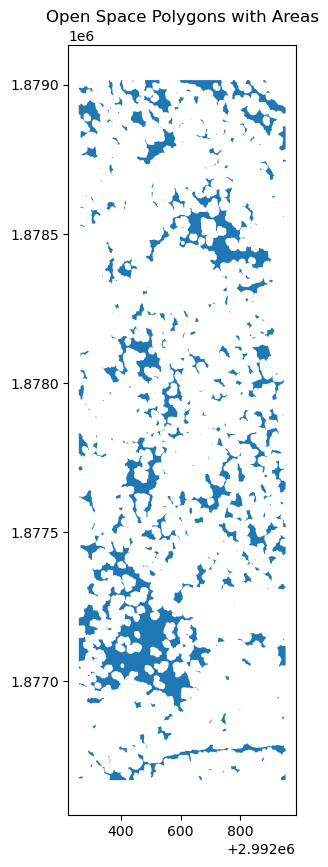

In [56]:
# plot
fig, ax = plt.subplots(figsize=(10, 10))
openspace_gdf3.plot(ax=ax)
plt.title("Open Space Polygons with Areas")

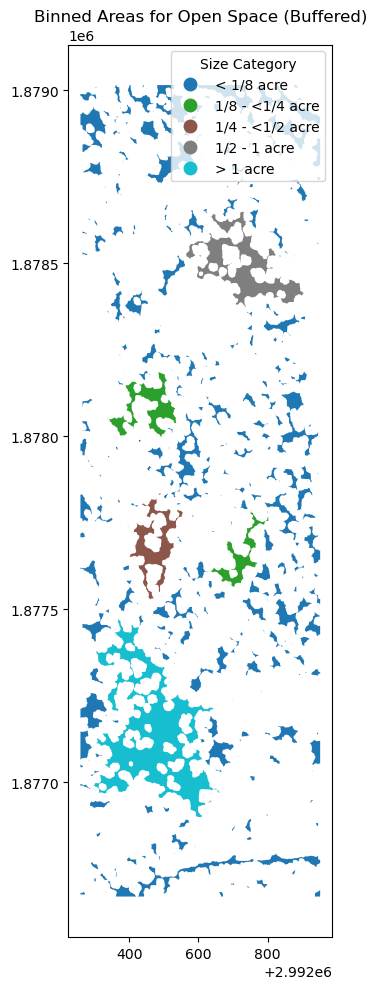

In [58]:
# Calculate areas and bin the open space polygons
openspace_gdf4 = calculate_area(openspace_gdf3)
bin_plot(openspace_gdf4, bins, labels, "Binned Areas for Open Space (Buffered)")